## Modeling Housing Cost  
### Gradient Boosting Built from First Principles


In [17]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
from scipy.stats import boxcox

import sys
sys.path.append('..')

from models.tree_models.gradient_boosting import GradientBoostingRegressor


In [18]:
import os
df = pd.read_csv(os.path.join('..', 'data', 'raw', 'ad_housing','train.csv'))
df_test = pd.read_csv(os.path.join('..', 'data', 'raw', 'ad_housing','test.csv'))
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000



Original sales distribution:


c:\Users\takun\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 0, 'SalePrice')

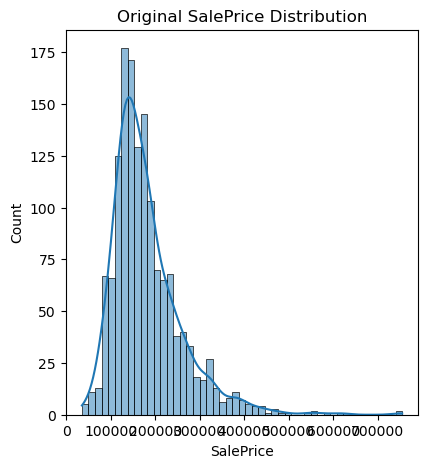

In [19]:
print("\nOriginal sales distribution:")
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(df["SalePrice"], kde=True)
plt.title("Original SalePrice Distribution")
plt.xlabel("SalePrice")


c:\Users\takun\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


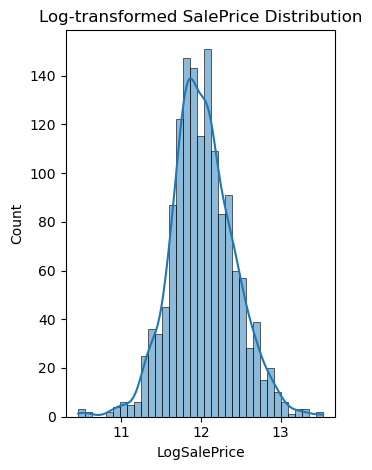

In [20]:
df['LogSalePrice'] = np.log1p(df['SalePrice'])

plt.subplot(1, 2, 2)
sns.histplot(df['LogSalePrice'], kde=True)
plt.title("Log-transformed SalePrice Distribution")
plt.xlabel("LogSalePrice")
plt.tight_layout()
plt.show()

In [21]:
print("\nMissing values summary:")
missing = df.isna().sum()
missing_cols = missing[missing > 0].sort_values(ascending=False)
print(missing_cols)


Missing values summary:
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64


In [22]:
df.drop(['Id'], axis=1, inplace=True)
df.replace(["?", "Unknown", "Null"], np.nan, inplace=True)

In [23]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

def build_preprocessor(df, target):
    """Build preprocessing pipeline for numeric and categorical features"""
    X = df.drop(columns=[target, 'SalePrice'])  # Drop both target and original price
    y = df[target]

    num_cols = X.select_dtypes(include=np.number).columns.tolist()
    cat_cols = X.select_dtypes(exclude=np.number).columns.tolist()
    
    print(f"\nNumeric features: {len(num_cols)}")
    print(f"Categorical features: {len(cat_cols)}")

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline([
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())
            ]), num_cols),

            ('cat', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype=np.float64))
            ]), cat_cols)
        ],
        remainder='drop'  # Explicitly drop any remaining columns
    )

    return X, y, preprocessor

In [24]:
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split,KFold

X, y, preprocessor = build_preprocessor(df, 'LogSalePrice')
X_processed = preprocessor.fit_transform(X)

X, y, preprocessor = build_preprocessor(df, 'LogSalePrice')

# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")

# Build the full pipeline
pipe = Pipeline([
    ("preprocess", preprocessor),
    ("select", SelectFromModel(
        GradientBoostingRegressor(
            n_estimators=50,  
            learning_rate=0.05,
            max_depth=3,
            random_state=42
        ),
        threshold="median"
    )),
    ("model", GradientBoostingRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    ))
])







Numeric features: 36
Categorical features: 43

Numeric features: 36
Categorical features: 43

Training set size: 1168
Validation set size: 292


In [ ]:
def custom_cross_val_score(model, X, y, cv=5):
    
    kfold = KFold(n_splits=cv, shuffle=True, random_state=42)
    scores = []
    
    # Convert to numpy arrays to handle indexing consistently
    X_array = np.array(X)
    y_array = np.array(y)
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_array), 1):
        X_fold_train, X_fold_val = X_array[train_idx], X_array[val_idx]
        y_fold_train, y_fold_val = y_array[train_idx], y_array[val_idx]
        
        # Create fresh model for each fold
        fold_model = GradientBoostingRegressor(
            n_estimators=model.n_estimators,
            learning_rate=model.learning_rate,
            max_depth=model.max_depth,
            min_samples_split=model.min_samples_split,
            min_samples_leaf=model.min_samples_leaf,
            random_state=42
        )
        
        # Fit and predict
        fold_model.fit(X_fold_train, y_fold_train)
        y_pred = fold_model.predict(X_fold_val)
        
        # Calculate RMSE
        rmse = np.sqrt(np.mean((y_fold_val - y_pred) ** 2))
        scores.append(rmse)
        print(f"Fold {fold}/5 - RMSE: {rmse:.4f}")
    
    return np.array(scores)

print("\n" + "="*50)
print("Performing 5-Fold Cross-Validation...")
print("="*50)


Performing 5-Fold Cross-Validation...


In [ ]:
# In your notebook, transform the data first:
X_processed = preprocessor.fit_transform(X)

# Then split or use the processed data for CV:
X_train_proc, X_val_proc, y_train, y_val = train_test_split(
    X_processed, y, test_size=0.2, random_state=42
)

# Create model instance
model = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

# Use the processed training data
scores = custom_cross_val_score(model, X_train_proc, y_train, cv=5)




print(f"\nCross-validation Results:")
print(f"Fold RMSE scores: {scores}")
print(f"Mean CV RMSE: {scores.mean():.4f}")
print(f"Std CV RMSE: {scores.std():.4f}")


print(f"\nCross-validation RMSE scores: {-scores}")
print(f"Mean CV RMSE: {-scores.mean():.4f}")
print(f"Std CV RMSE: {scores.std():.4f}")
print("Done")




Fold 1/5 - RMSE: 0.1295
Fold 2/5 - RMSE: 0.1391
Fold 3/5 - RMSE: 0.1564
Fold 4/5 - RMSE: 0.1161
Fold 5/5 - RMSE: 0.1061

Cross-validation Results:
Fold RMSE scores: [0.12948765 0.13912365 0.15636006 0.11607052 0.10611854]
Mean CV RMSE: 0.1294
Std CV RMSE: 0.0176

Cross-validation RMSE scores: [-0.12948765 -0.13912365 -0.15636006 -0.11607052 -0.10611854]
Mean CV RMSE: -0.1294
Std CV RMSE: 0.0176


In [ ]:
# Train final model on full training set
print("\n" + "="*50)
print("Training final model on full training set...")
print("="*50)

final_model = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

final_model.fit(X_train_proc, y_train)

# Evaluate on validation set
y_pred_train = final_model.predict(X_train_proc)
y_pred_val = final_model.predict(X_val_proc)

# Calculate metrics
train_rmse = np.sqrt(np.mean((y_train - y_pred_train) ** 2))
val_rmse = np.sqrt(np.mean((y_val - y_pred_val) ** 2))

# R² score
train_r2 = final_model.score(X_train_proc, y_train)
val_r2 = final_model.score(X_val_proc, y_val)

print(f"\nTraining Set Performance:")
print(f"RMSE: {train_rmse:.4f}")
print(f"R² Score: {train_r2:.4f}")

print(f"\nValidation Set Performance:")
print(f"RMSE: {val_rmse:.4f}")
print(f"R² Score: {val_r2:.4f}")

# Convert back from log scale for interpretation
y_val_original = np.expm1(y_val)
y_pred_original = np.expm1(y_pred_val)
rmse_original = np.sqrt(np.mean((y_val_original - y_pred_original) ** 2))

print(f"\nOriginal Scale RMSE: ${rmse_original:,.2f}")


Training final model on full training set...

Training Set Performance:
RMSE: 0.0665
R² Score: 0.9710

Validation Set Performance:
RMSE: 0.1425
R² Score: 0.8912

Original Scale RMSE: $33,472.60


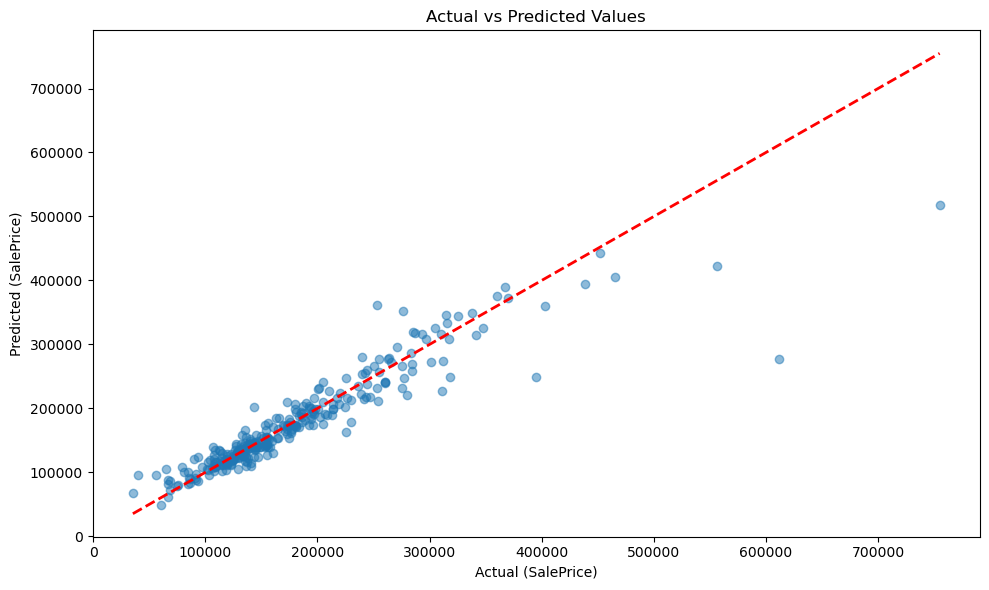

In [ ]:
# Plot predictions vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y_val_original, y_pred_original, alpha=0.5)
plt.plot([y_val_original.min(), y_val_original.max()], [y_val_original.min(), y_val_original.max()], 'r--', lw=2)
plt.xlabel('Actual (SalePrice)')
plt.ylabel('Predicted (SalePrice)')
plt.title('Actual vs Predicted Values')
plt.tight_layout()
plt.show()



c:\Users\takun\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[]

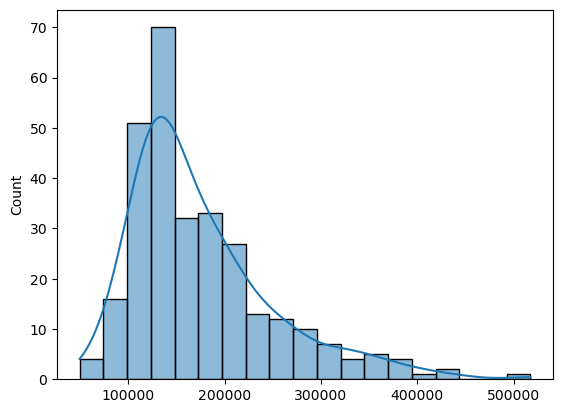

In [27]:
sns.histplot(y_pred_original,kde=True)
plt.plot()

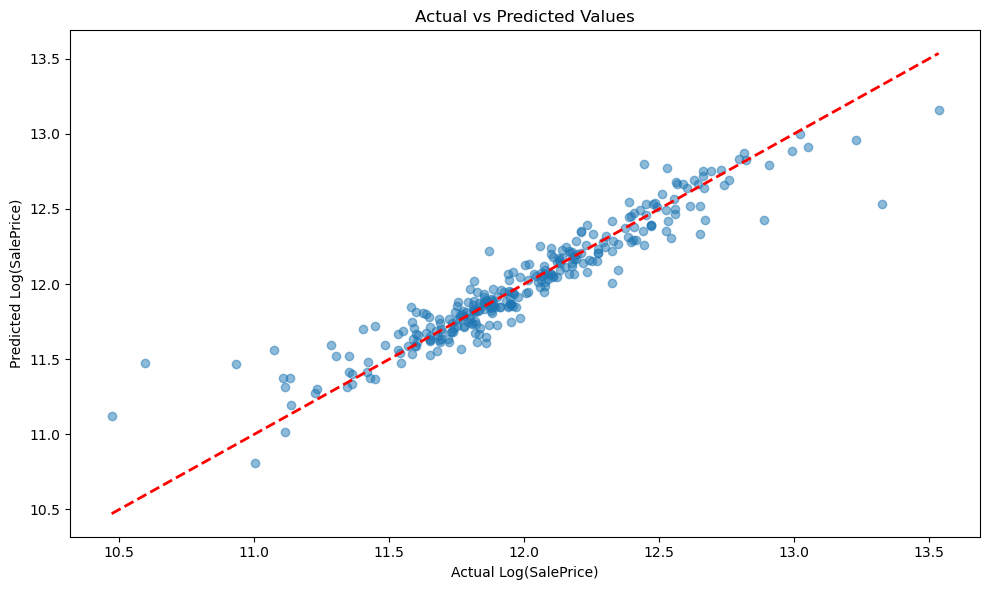

In [ ]:
# Plot predictions vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred_val, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Actual Log(SalePrice)')
plt.ylabel('Predicted Log(SalePrice)')
plt.title('Actual vs Predicted Values')
plt.tight_layout()
plt.show()

